# Fellowship.AI Challenge
This notebook is to use Collaborative Filtering and NMF&SVD to recommend movie to users.

We pick a lucky user whose user_id = 100 and recommend top 10 movies to him.

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from time import time

## Load data to pandas

In [2]:
movie = pd.read_table('movies.dat', sep='::', names=['movie_id', 'movie_name', 'tag'], engine='python')
rating = pd.read_table("ratings.dat", sep="::",
                           names=["user_id", "movie_id", "rating", "timestamp"], engine='python')
user=pd.read_table('users.dat',sep='::',names=['user_id','gender','age','occupation','zip-code'],engine='python')
##sep:Delimiter to use, names:List of column names to use

In [3]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
user_id      1000209 non-null int64
movie_id     1000209 non-null int64
rating       1000209 non-null int64
timestamp    1000209 non-null int64
dtypes: int64(4)
memory usage: 30.5 MB


In [23]:
rating.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [19]:
user.head()

,user_id,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [26]:
rating.describe()

,user_id,movie_id,rating,timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


## Convert rating records to user-movie utility matrix

use pandas.pivot_table

In [3]:
utility = pd.pivot_table(data=rating, 
                            values='rating', 
                            index='user_id', 
                            columns='movie_id', 
                            fill_value=0)

In [29]:
utility.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
utility.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6040 entries, 1 to 6040
Columns: 3706 entries, 1 to 3952
dtypes: int64(3706)
memory usage: 170.8 MB


we find that there are lots of zeros in the matrix so we convert to sparse matrix using scipy.sparse.lil_matrix

In [4]:
highest_user_id = rating.user_id.max()
highest_movie_id = rating.movie_id.max()
ratings_mat = sparse.lil_matrix((highest_user_id, highest_movie_id))
ratings_mat

<6040x3952 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in LInked List format>

In [5]:
for _, row in rating.iterrows():
    # subtract 1 from id's due to match 0 indexing
    ratings_mat[row.user_id-1, row.movie_id-1] = row.rating

In [6]:
ratings_mat

<6040x3952 sparse matrix of type '<class 'numpy.float64'>'
	with 1000209 stored elements in LInked List format>

## Calculate item-item similarity matrix

In [7]:
utility_mat=ratings_mat

In [8]:
utility_mat.T

<3952x6040 sparse matrix of type '<class 'numpy.float64'>'
	with 1000209 stored elements in LInked List format>

In [9]:
# Item-Item Similarity Matrix
item_sim_mat = cosine_similarity(utility_mat.T)


In [10]:
item_sim_mat

array([[1.        , 0.39034871, 0.26794263, ..., 0.09347942, 0.04282933,
        0.18269056],
       [0.39034871, 1.        , 0.24094645, ..., 0.08701306, 0.02606255,
        0.12218461],
       [0.26794263, 0.24094645, 1.        , ..., 0.0622576 , 0.01007255,
        0.097786  ],
       ...,
       [0.09347942, 0.08701306, 0.0622576 , ..., 1.        , 0.20280851,
        0.2346385 ],
       [0.04282933, 0.02606255, 0.01007255, ..., 0.20280851, 1.        ,
        0.19297221],
       [0.18269056, 0.12218461, 0.097786  , ..., 0.2346385 , 0.19297221,
        1.        ]])

## Calculate neighborhood

In [11]:
# sort,result from min to max
least_to_most_sim_indexes = np.argsort(item_sim_mat, axis=1)

# Neighborhoods
neighborhood_size = 75
neighborhoods = least_to_most_sim_indexes[:, -neighborhood_size:]

In [12]:
neighborhoods.shape

(3952, 75)

In [13]:
neighborhoods

array([[ 589,  149,  550, ..., 1264, 3113,    0],
       [1875, 1195, 2640, ...,  652, 3488,    1],
       [1887,  376,  316, ...,  586, 3449,    2],
       ...,
       [2319, 1457,  447, ..., 2768, 3948, 3949],
       [ 578, 3311,  643, ..., 3191, 3914, 3950],
       [3622, 3565, 3949, ..., 3892, 3896, 3951]], dtype=int64)

## Make rating prediction on a user


In [14]:
# Let's pick a lucky user
user_id = 100
items_rated_by_this_user=ratings_mat[user_id].nonzero()[1]
items_rated_by_this_user

array([  20,   70,  144,  164,  207,  259,  291,  328,  359,  367,  375,
        376,  379,  419,  465,  473,  479,  484,  545,  551,  588,  647,
        735,  779,  848, 1010, 1035, 1195, 1197, 1199, 1209, 1213, 1239,
       1274, 1286, 1319, 1355, 1370, 1371, 1372, 1373, 1374, 1375, 1384,
       1437, 1543, 1551, 1561, 1579, 1586, 1675, 1721, 1800, 1834, 1875,
       1953, 1999, 2000, 2005, 2093, 2272, 2352, 2401, 2403, 2404, 2405,
       2408, 2410, 2411, 2420, 2523, 2570, 2615, 2616, 2627, 2639, 2641,
       2698, 2722, 2734, 2762, 2793, 2825, 2871, 2915, 2946, 2947, 2948,
       2990, 3081, 3207, 3258, 3267, 3396, 3417, 3437, 3439, 3526, 3554,
       3696, 3754, 3792, 3840, 3935, 3945, 3947], dtype=int32)

In [64]:
n_users = utility_mat.shape[0]
n_items = utility_mat.shape[1]

start_time = time()
# Just initializing so we have somewhere to put rating preds
out = np.zeros(n_items)
for item_to_rate in range(n_items):
    relevant_items = np.intersect1d(neighborhoods[item_to_rate],
                                    items_rated_by_this_user,
                                    assume_unique=True)  # assume_unique speeds up intersection op
    out[item_to_rate] = ratings_mat[user_id, relevant_items] * \
        item_sim_mat[item_to_rate, relevant_items] / \
        item_sim_mat[item_to_rate, relevant_items].sum()


pred_ratings = np.nan_to_num(out)
print(pred_ratings)
print("Execution time: %f seconds" % (time()-start_time))

e:\python\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


[4.82368197 4.88525636 5.         ... 5.         0.         4.74581838]
Execution time: 1.171328 seconds


In [65]:
pred_ratings.shape

(3952,)

## Get final recommendations for a user¶

In [67]:
# Recommend n movies
n = 10

# Get item indexes sorted by predicted rating
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))

# Find items that have been rated by user
items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]

# We want to exclude the items that have been rated by user
unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]

unrated_items_by_pred_rating[-n:]


[867, 1877, 2161, 1842, 2804, 901, 101, 2097, 1712, 1222]

# NMF_UVD for Recommender

In [8]:
utility.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
ratings_mat

<6040x3952 sparse matrix of type '<class 'numpy.float64'>'
	with 1000209 stored elements in LInked List format>

## Compute NMF

In [19]:
# k:latent factor, W: 
from sklearn.decomposition import NMF
M=ratings_mat
def fit_nmf(k):
    nmf = NMF(n_components =k)
    nmf.fit(M)
    W = nmf.transform(M);   
    H = nmf.components_;
    return nmf.reconstruction_err_
error = [fit_nmf(i) for i in range(1,10)]

Text(0,0.5,'Reconstruction Errror')

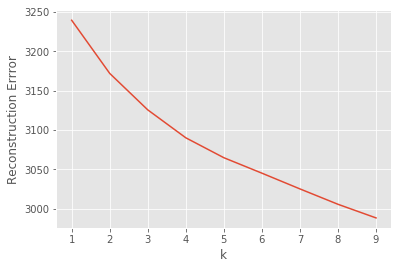

In [21]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib inline


plt.plot(range(1,10), error)
plt.xlabel('k')
plt.ylabel('Reconstruction Errror')
## elbow k=4

In [29]:
nmf = NMF(n_components=4)
nmf.fit(M)
W = nmf.transform(M);  #user_distribution
H = nmf.components_;   #item_distribution
print ('RSS = %.2f' % nmf.reconstruction_err_)
W,H

RSS = 3089.99


(array([[0.00608709, 0.11095198, 0.15713003, 0.15807626],
        [0.29470424, 0.19036509, 0.27522735, 0.05391473],
        [0.19771426, 0.06412023, 0.07167147, 0.0863111 ],
        ...,
        [0.01138968, 0.07474362, 0.01854071, 0.02344415],
        [0.        , 0.67301982, 0.        , 0.08168535],
        [0.03071986, 1.36280359, 0.50613503, 0.        ]]),
 array([[1.37999091e+00, 8.23952446e-01, 1.72038648e-03, ...,
         4.63324668e-03, 0.00000000e+00, 0.00000000e+00],
        [6.44992633e-01, 0.00000000e+00, 0.00000000e+00, ...,
         7.65766314e-02, 2.58495893e-02, 1.61490760e-01],
        [1.83428896e+00, 0.00000000e+00, 6.91750813e-02, ...,
         9.69340501e-02, 8.50328818e-02, 8.39101759e-01],
        [2.03233738e+00, 1.34378438e+00, 1.20643482e+00, ...,
         2.60474687e-02, 0.00000000e+00, 3.09782268e-02]]))

In [30]:
# reconstruct
ratings_mat_fitted = W.dot(H)
errs = np.array((ratings_mat-ratings_mat_fitted).flatten()).squeeze()
mask = np.array((ratings_mat.todense()).flatten()).squeeze()>0

mse = np.mean(errs[mask]**2)
average_abs_err = abs(errs[mask]).mean()
print(mse)
print (average_abs_err)

7.570333099092337
2.4685121270706425


In [33]:
print (np.around(W.dot(H),2))
#print (pd.DataFrame(M, index=user, columns=movie))

[[0.69 0.22 0.2  ... 0.03 0.02 0.15]
 [1.14 0.32 0.08 ... 0.04 0.03 0.26]
 [0.62 0.28 0.11 ... 0.02 0.01 0.07]
 ...
 [0.15 0.04 0.03 ... 0.01 0.   0.03]
 [0.6  0.11 0.1  ... 0.05 0.02 0.11]
 [1.85 0.03 0.04 ... 0.15 0.08 0.64]]


## Get recommendations for one user

In [36]:

user_id = 100
n = 10

pred_ratings = ratings_mat_fitted[user_id,:]
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]

unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]

unrated_items_by_pred_rating[:n]

[109, 1290, 1126, 1526, 1609, 540, 456, 2027, 1269, 2984]

In [ ]:
[867, 1877, 2161, 1842, 2804, 901, 101, 2097, 1712, 1222]

In [38]:
### check errors
# truth
ratings_true = ratings_mat[user_id, items_rated_by_this_user].todense()
# prediction
ratings_pred = pred_ratings[items_rated_by_this_user]
print (zip(np.array(ratings_true).squeeze(),ratings_pred))
err_one_user = ratings_true-ratings_pred
print (err_one_user)
print (abs(err_one_user).mean())

[[ 3.11095083  3.89912098  4.49838457  2.72210153  3.24684451  1.22256077
   4.12237712  3.15913178  4.96706264  4.1031807   3.68726157  3.33329666
   3.47757615  4.74039377  4.48121912  2.90108498  1.78491147  4.52413949
   4.70284053  4.46686851  1.47044262  3.33305544  3.89203255  2.48059807
   3.22370516  4.94597509  2.53536296  1.37109968  1.95425835 -0.13543317
   1.47874193 -0.03388805  1.54796254  3.38248613  4.10102097  1.56474815
   2.51403764  3.69762607  3.06117375  4.07242596  1.23398573  3.3071714
   2.88632755  3.23063463  4.60571092  3.37355963  3.82210331  4.50349407
   2.09596222  2.97416472  3.11479595  3.85481954  4.67963915  2.93947672
   3.72103538  3.63211511  2.06303762  3.73125238  3.82829723  3.84878354
   4.07732679  3.60973312  4.45391721  4.65283242  4.40469537  3.64495529
   4.52463066  4.64914396  4.7737224   4.63534501  3.77171058  1.3475165
   3.51318986  3.59743089  2.29335507  3.17014025  4.45339935  3.80293244
   3.41682273  2.59333787  4.01193507  4

In [39]:
from sklearn.decomposition import TruncatedSVD

def fit_uvd(M,k):
    # use TruncatedSVD to realize UVD
    svd = TruncatedSVD(n_components=k, n_iter=7, random_state=0)
    svd.fit(M)

    V = svd.components_
    U = svd.transform(M) # effectively, it's doing: U = M.dot(V.T)
    # we can ignore svd.singular_values_ for our purpose
    
    # why we can do this?
    # recall: 
    # SVD start from u*s*v=M => u*s=M*v.T, where M*v.T is our transformation above to get U in UVD
    # so the above U is effectively u*s in SVD
    # that's why U*V = u*s*v = M our original matrix
    # there are many ways to understand it!
    # here we by-passed singular values.
    
    return U,V

# decompose
U,V = fit_uvd(ratings_mat,200)

In [41]:
print (M.shape, U.shape,V.shape)

(6040, 3952) (6040, 200) (200, 3952)


In [42]:
# reconstruct
ratings_mat_fitted = U.dot(V) # U*V
# recall: U = M.dot(V.T), then this is M.dot(V.T).dot(V)
# original M is transformed to new space, then transformed back
# this is another way to understand it!

# calculate errs
errs = np.array((ratings_mat-ratings_mat_fitted).flatten()).squeeze()
mask = np.array((ratings_mat.todense()).flatten()).squeeze()>0

mse = np.mean(errs[mask]**2)
average_abs_err = abs(errs[mask]).mean()
print(mse)
print(average_abs_err)

3.2804334045784835
1.4667071367693063


In [48]:
# with the above "tranformed to the new space and back" language
# without the UV language, we can do:
M = ratings_mat
k = 200
svd = TruncatedSVD(n_components=k, n_iter=7, random_state=0)
svd.fit(M)
M_prime = svd.inverse_transform(svd.transform(M))
print(sum(sum(U.dot(V) - M_prime)))
# they are just equivalent!!

0.0


In [45]:
# get recommendations for one user
user_id = 100
n = 10

pred_ratings = ratings_mat_fitted[user_id,:]
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]

unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]

unrated_items_by_pred_rating[:n]

[2392, 2001, 315, 1376, 1369, 9, 1290, 2640, 1916, 2114]

In [46]:
### check errors
# truth
ratings_true = ratings_mat[user_id, items_rated_by_this_user].todense()
# prediction
ratings_pred = pred_ratings[items_rated_by_this_user]
print (zip(np.array(ratings_true).squeeze(),ratings_pred))
err_one_user = ratings_true-ratings_pred
print (err_one_user)
print (abs(err_one_user).mean())

[[ 1.77922289  3.61790386  3.69996139  1.61400639  1.45201229 -0.1530598
   2.12536715  0.12330756  4.36119611  2.09799257  2.86814676  1.74975454
   1.96271629  3.53630415  3.67781691  2.67747568 -0.17820627  3.18027265
   4.25115894  2.94955565  0.11981971  1.26911878  1.53869182  1.06475342
   3.32863469  4.59574882  1.45411614  0.27882436  0.41499422  0.3580589
   0.34237072 -0.31245358  0.06234184  3.32602012  2.95075967  1.4307268
   0.09006028  1.76771907  0.43805002  2.37458367 -0.95275658  1.49689182
   0.55740632  1.99986849  3.68914213  1.18850623  2.78424278  3.09280768
   0.67766351  2.2198343   2.09072744  2.18468716  3.53254958  2.90252146
   2.55931871  0.77663647  0.82505972  2.37786082  1.83608234  3.29495305
   2.86799001  3.16755176  3.48425285  4.02562805  2.56015288  1.22978152
   2.55054735  3.27950547  3.80429143  3.01131363  3.05609133  0.09531123
   2.34773337  2.16013966  0.29247647  2.08729413  3.4117339   3.434807
   2.18064041  1.89297724  2.24845725  4.41